In [2]:
# Library Installs
!pip install sweetviz

# Library Imports
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import sweetviz as sv
import seaborn as sn

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer, SnowballStemmer
from nltk import ngrams

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
warnings.filterwarnings('ignore')
%autosave 60
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Autosaving every 60 seconds


In [3]:
from google.colab import files

uploaded = files.upload()

Saving item_recommender.py to item_recommender.py


In [4]:
from google.colab import files

uploaded = files.upload()

Saving ted_main.csv to ted_main.csv
Saving transcripts.csv to transcripts.csv


In [5]:
# Data Visibility
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', None)


# Import data
df1 = pd.read_csv('ted_main.csv')
df2 = pd.read_csv('transcripts.csv')

In [6]:
# Merge Data
df = df1.merge(df2)

## Exploring Data/ EDA/ Data Analysis


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2467 entries, 0 to 2466
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   comments            2467 non-null   int64 
 1   description         2467 non-null   object
 2   duration            2467 non-null   int64 
 3   event               2467 non-null   object
 4   film_date           2467 non-null   int64 
 5   languages           2467 non-null   int64 
 6   main_speaker        2467 non-null   object
 7   name                2467 non-null   object
 8   num_speaker         2467 non-null   int64 
 9   published_date      2467 non-null   int64 
 10  ratings             2467 non-null   object
 11  related_talks       2467 non-null   object
 12  speaker_occupation  2461 non-null   object
 13  tags                2467 non-null   object
 14  title               2467 non-null   object
 15  url                 2467 non-null   object
 16  views               2467

In [8]:
df.head(5)

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views,transcript
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110,Good morning. How are you?(Laughter)It's been ...
1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520,"Thank you so much, Chris. And it's truly a gre..."
2,124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292,"(Music: ""The Sound of Silence,"" Simon & Garfun..."
3,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,1140912000,35,Majora Carter,Majora Carter: Greening the ghetto,1,1151367060,"[{'id': 3, 'name': 'Courageous', 'count': 760}...","[{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...",Activist for environmental justice,"['MacArthur grant', 'activism', 'business', 'c...",Greening the ghetto,https://www.ted.com/talks/majora_carter_s_tale...,1697550,If you're here today — and I'm very happy that...
4,593,You've never seen data presented like this. Wi...,1190,TED2006,1140566400,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,1151440680,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","[{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...",Global health expert; data visionary,"['Africa', 'Asia', 'Google', 'demo', 'economic...",The best stats you've ever seen,https://www.ted.com/talks/hans_rosling_shows_t...,12005869,"About 10 years ago, I took on the task to teac..."


In [9]:
# x = df.sort_values(by='views')
# x.tail(5)
df.name.iloc[649]

'Simon Sinek: How great leaders inspire action'

                                             |          | [  0%]   00:00 -> (? left)

Report sweet_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



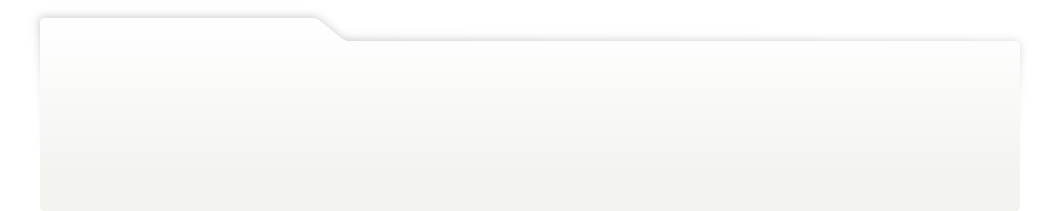
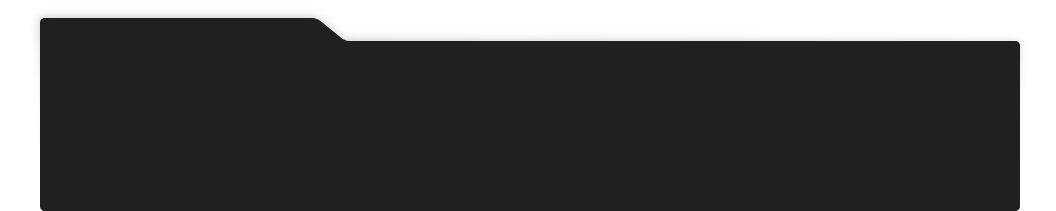
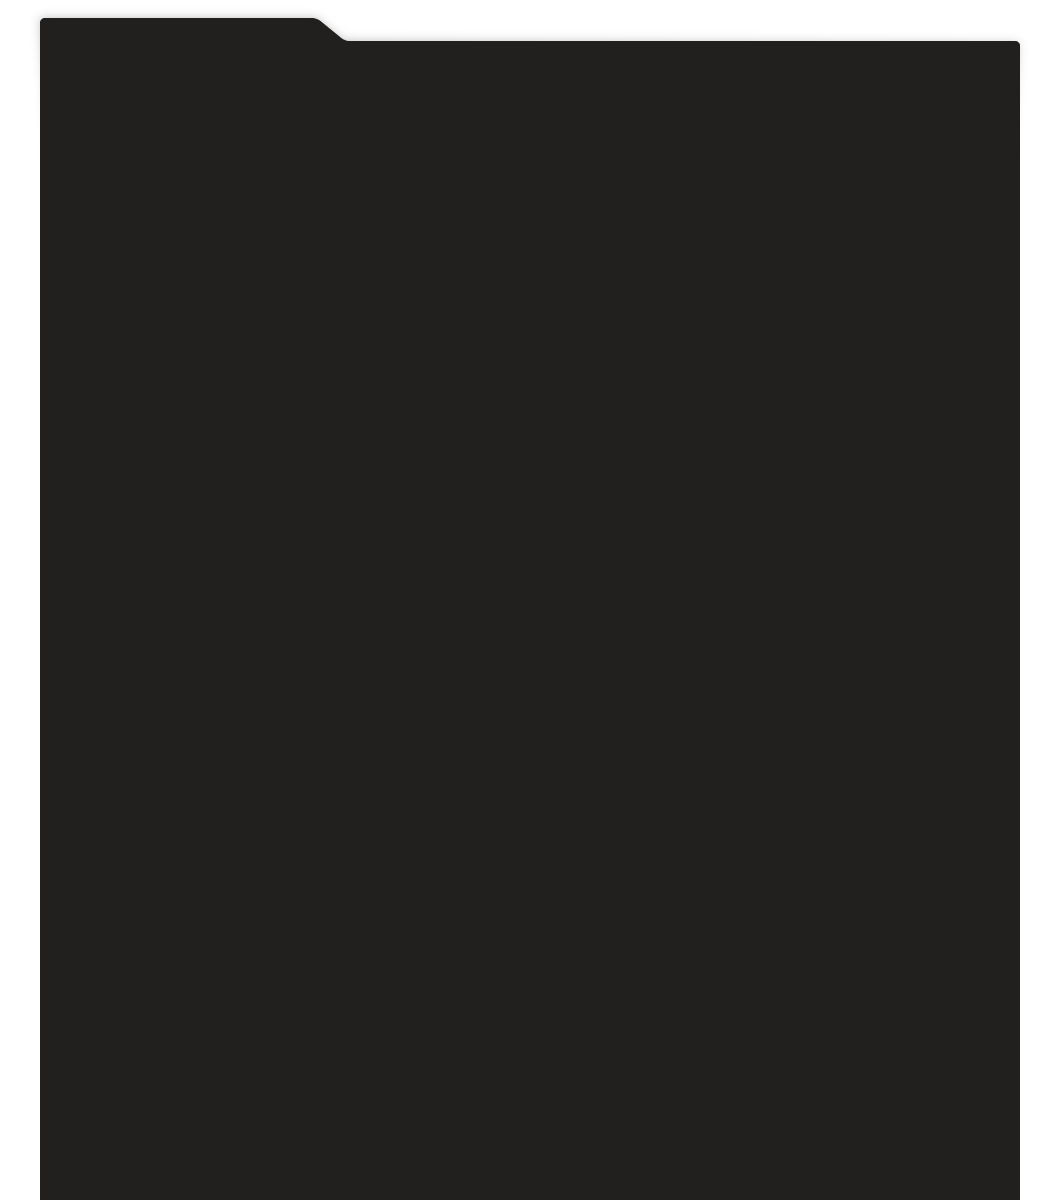
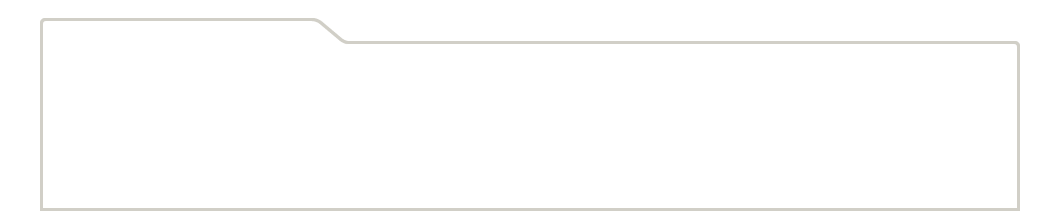
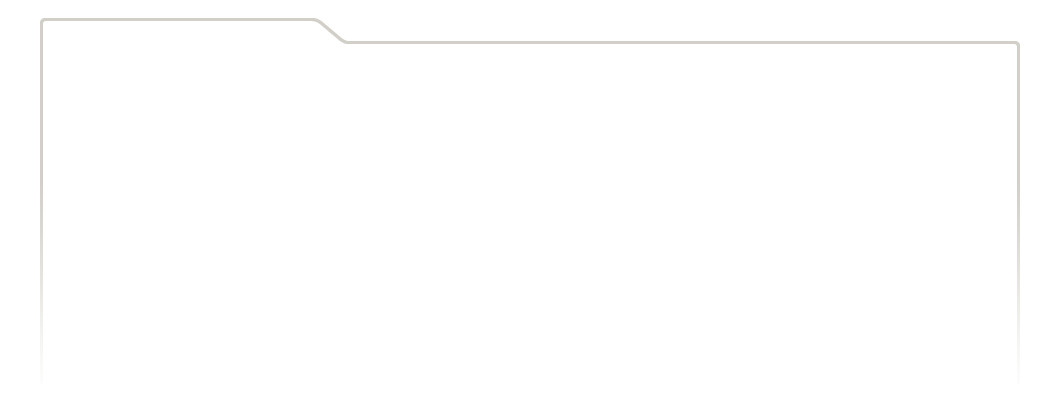
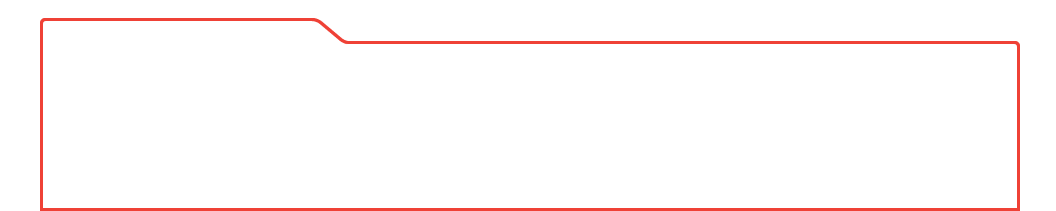
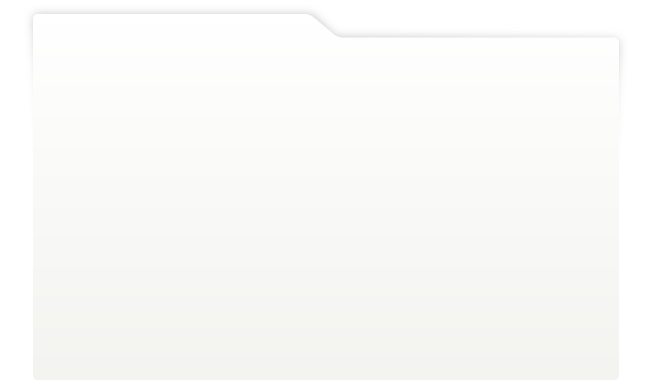
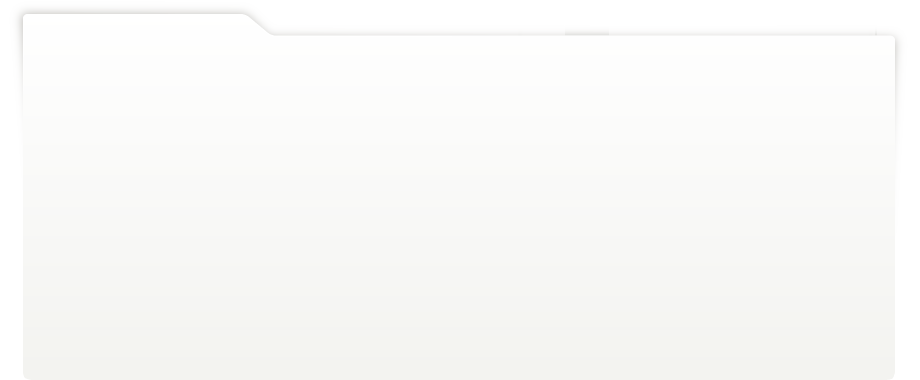
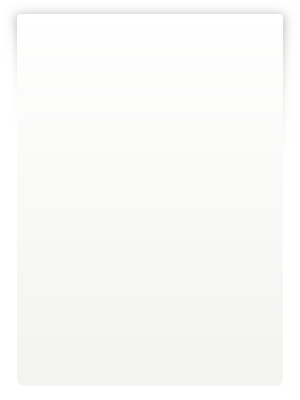
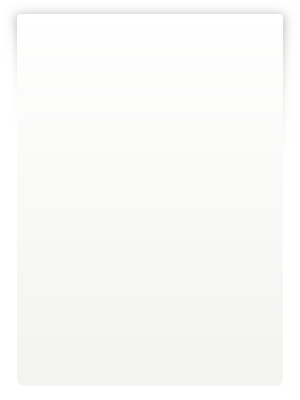
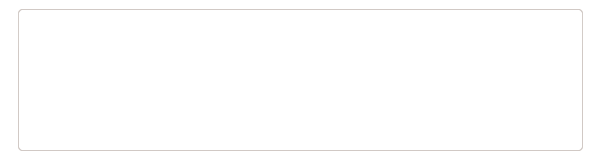
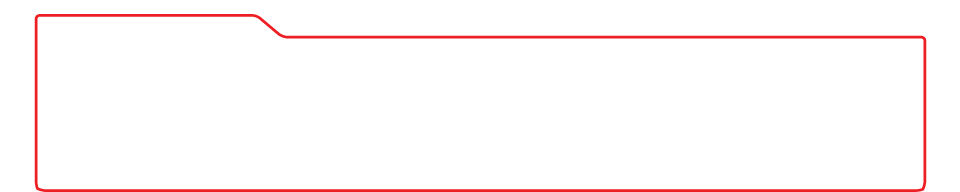
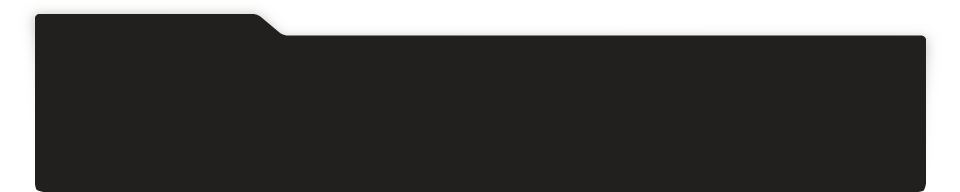
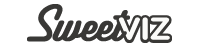
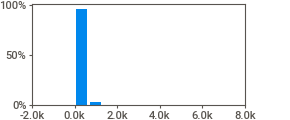
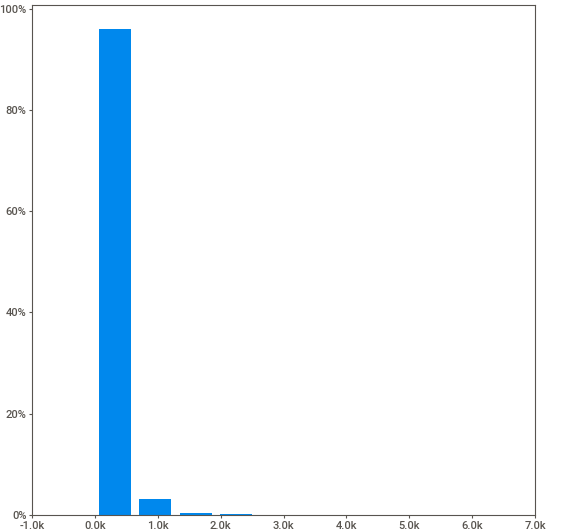
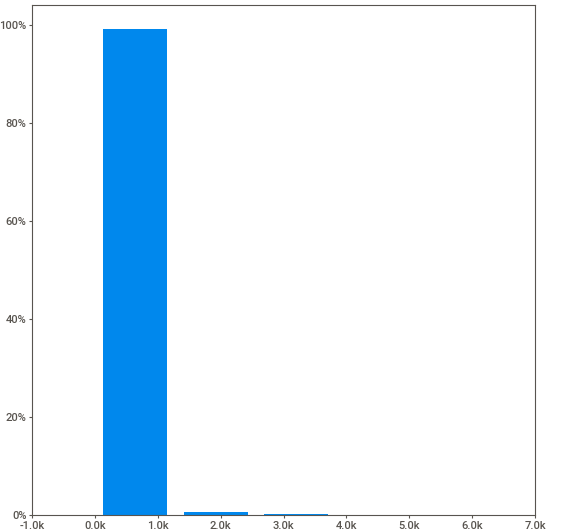
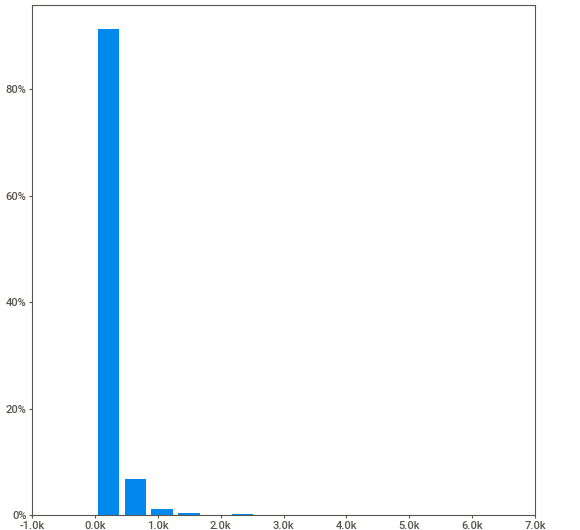
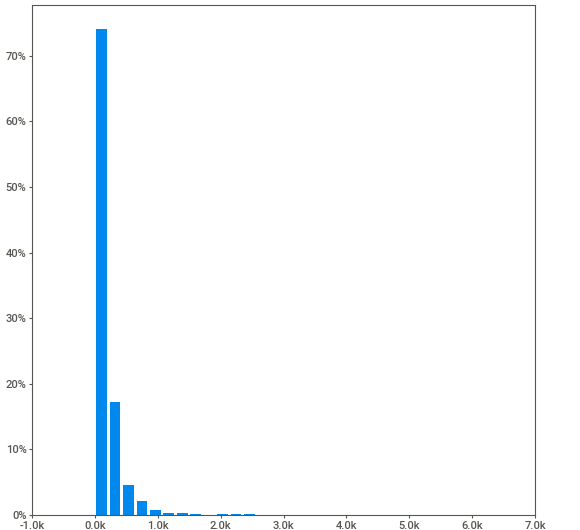
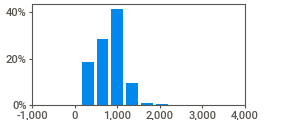
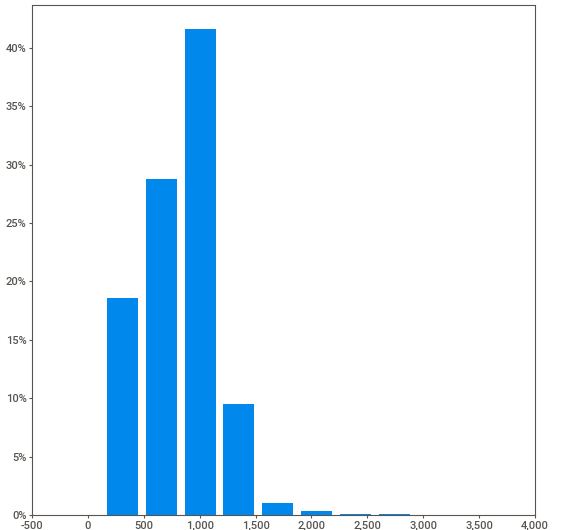
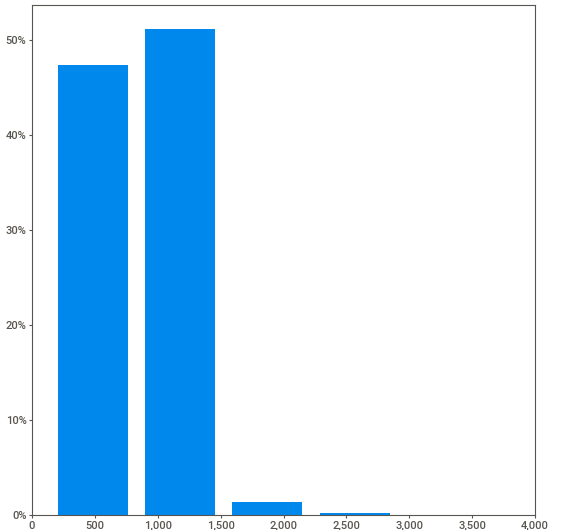
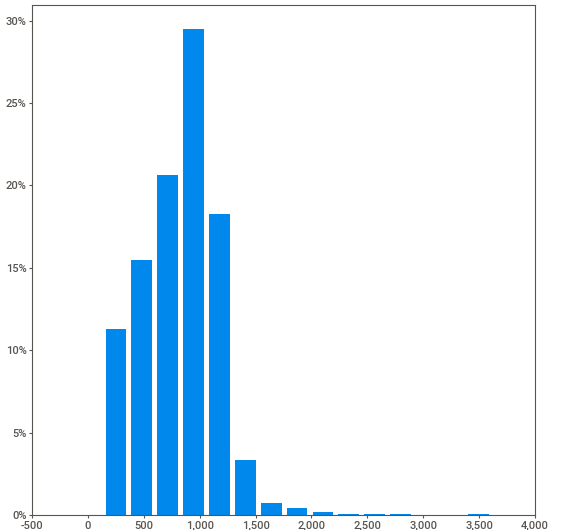
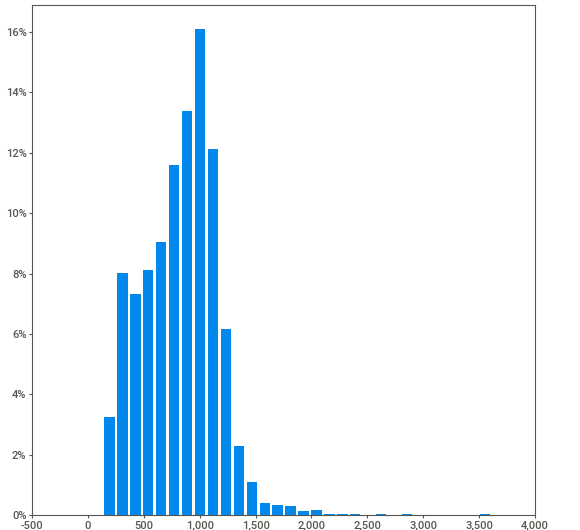
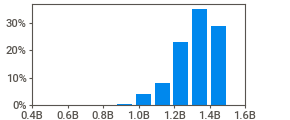
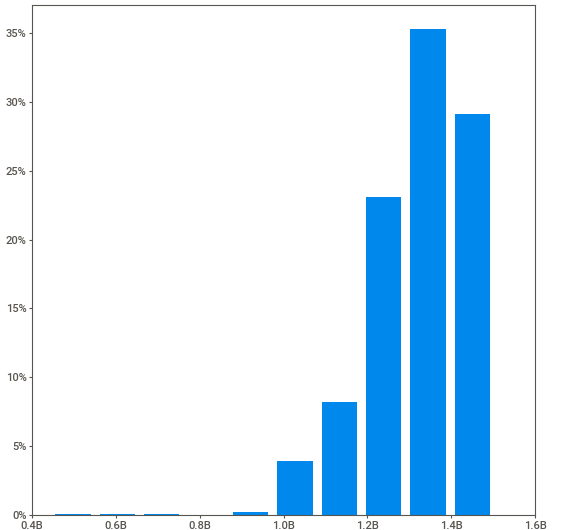
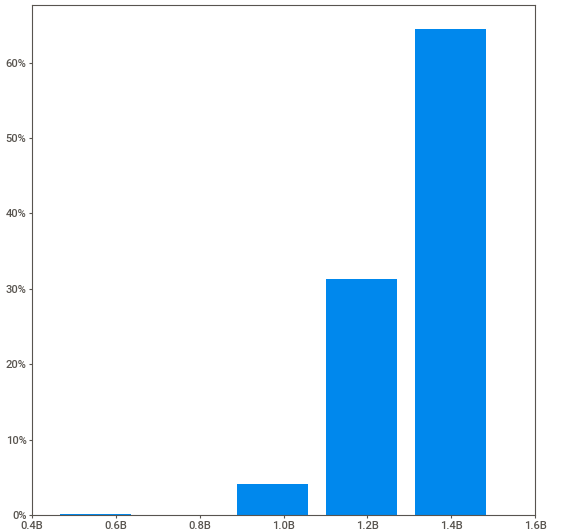
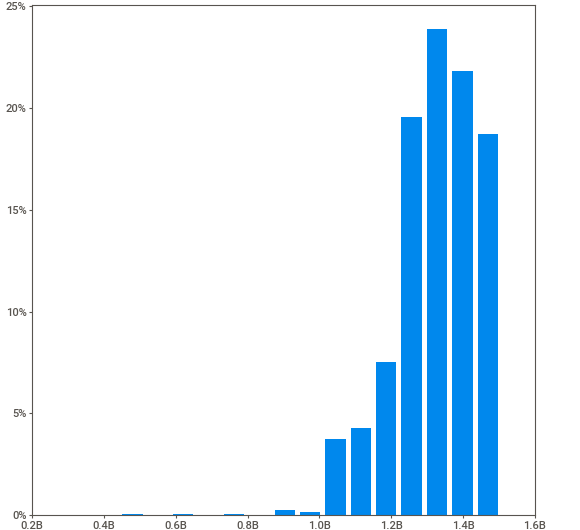
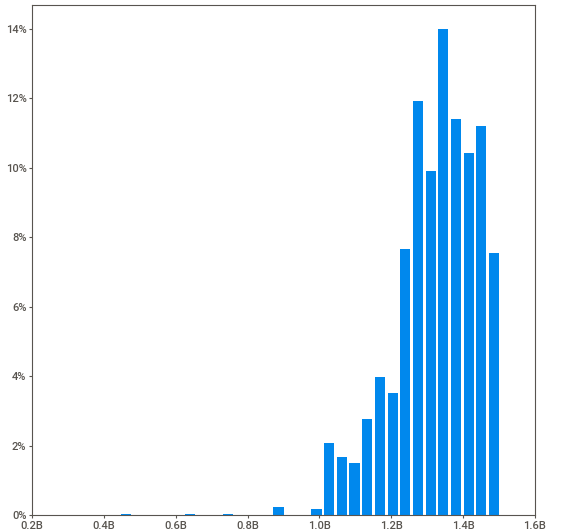
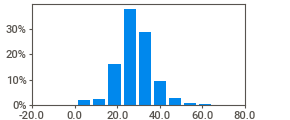
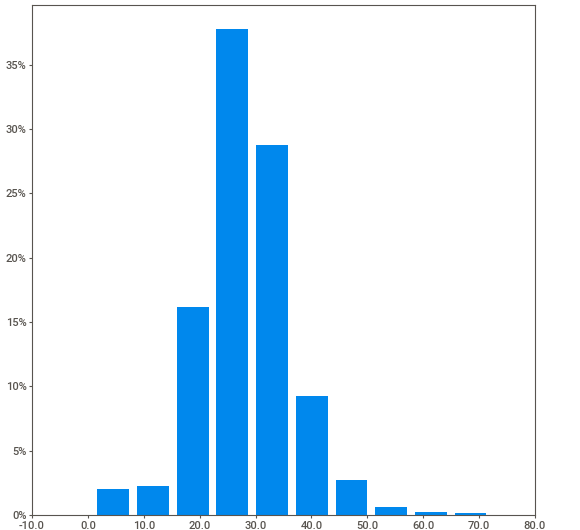
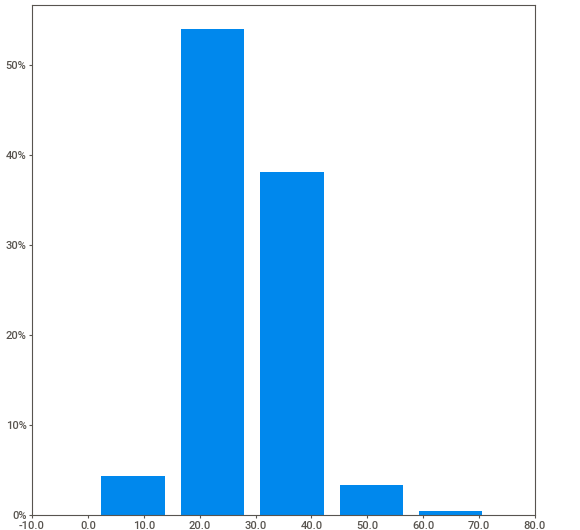
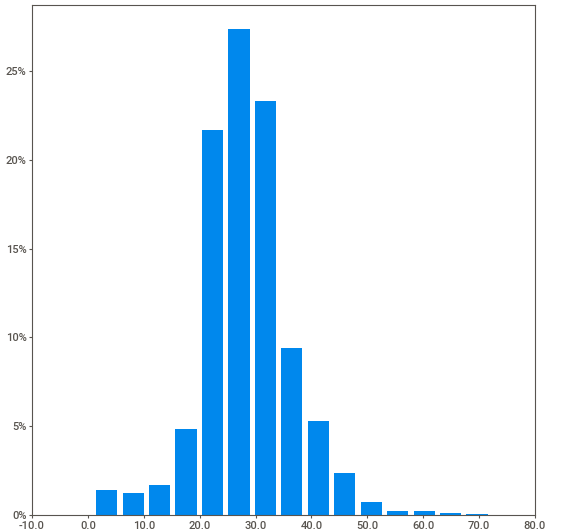
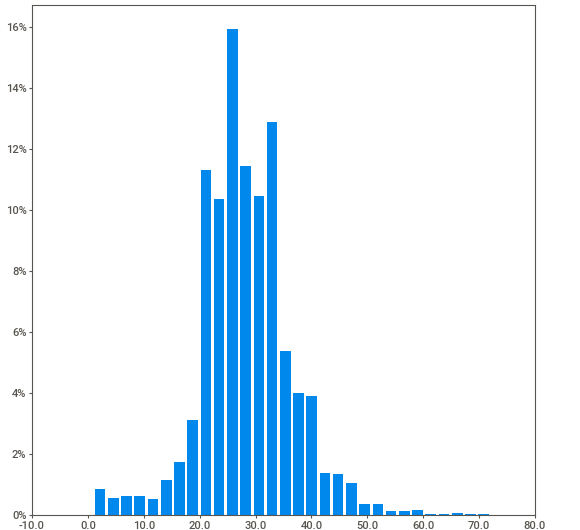
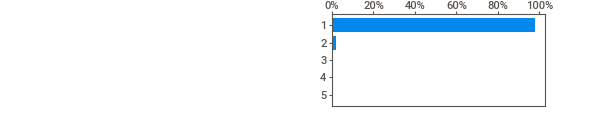
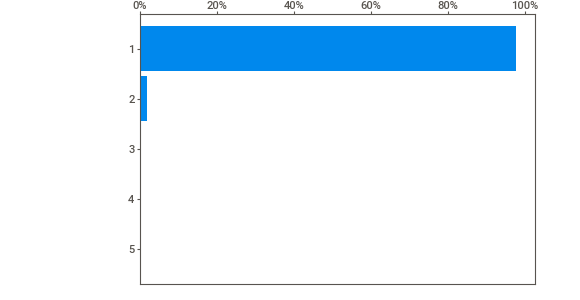
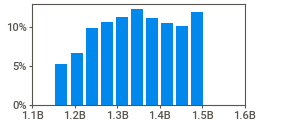
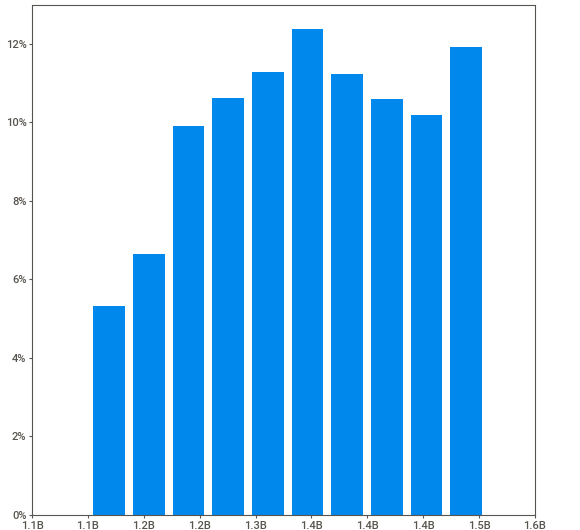
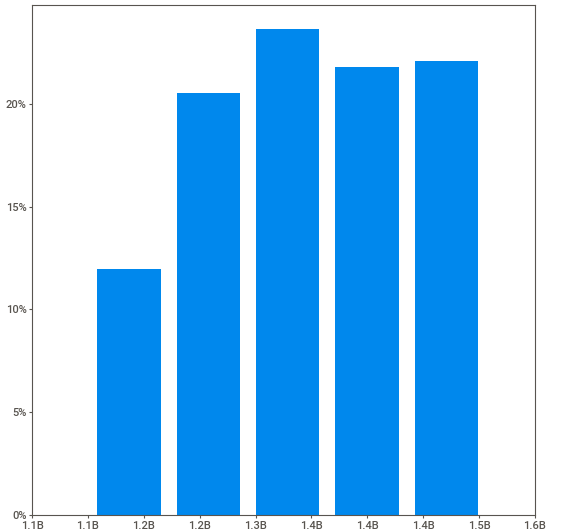
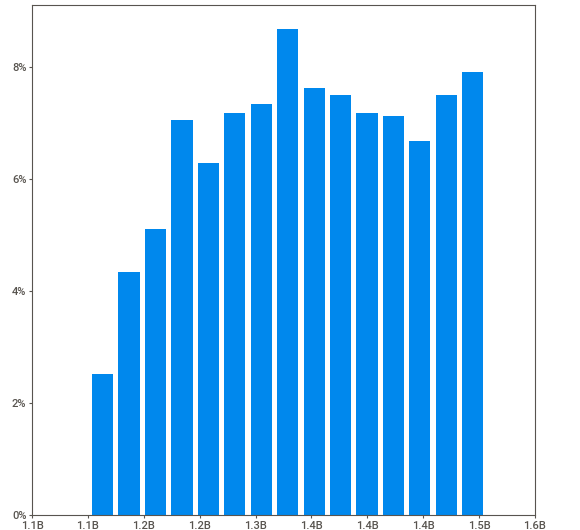
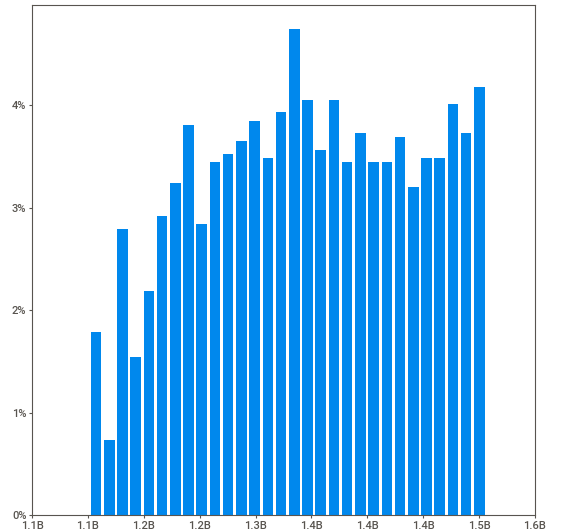
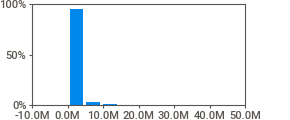
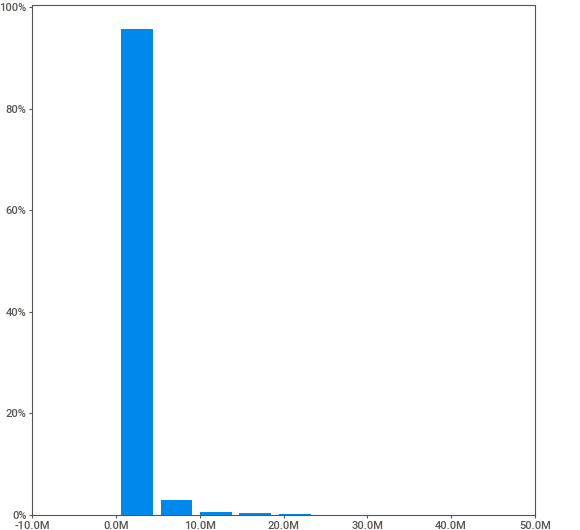
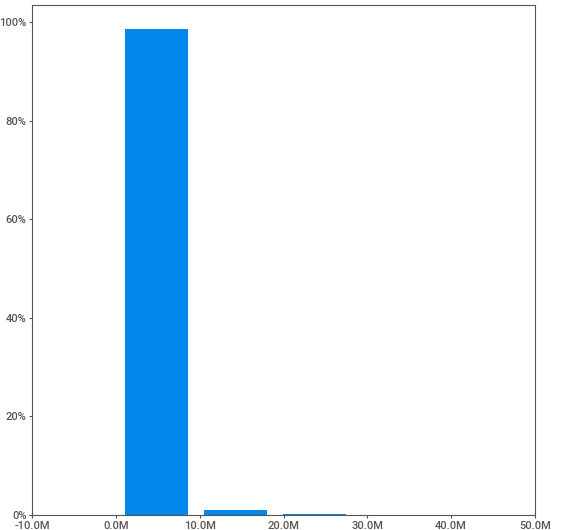
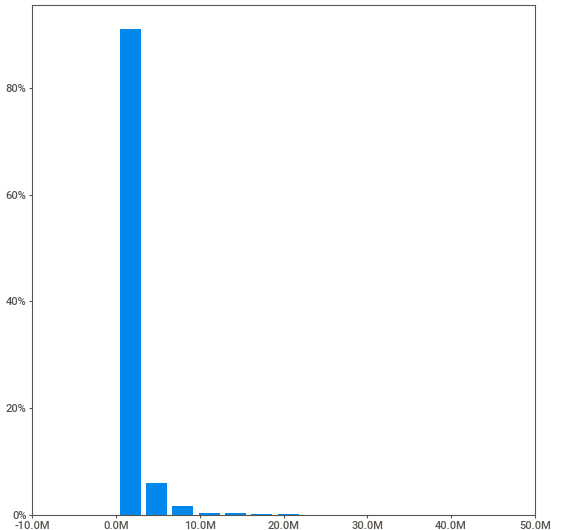
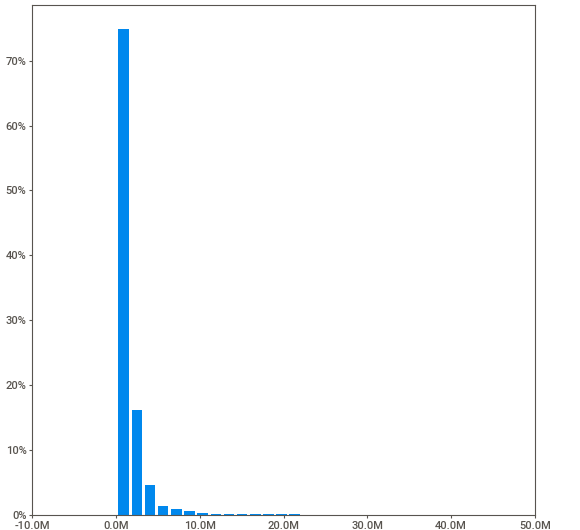
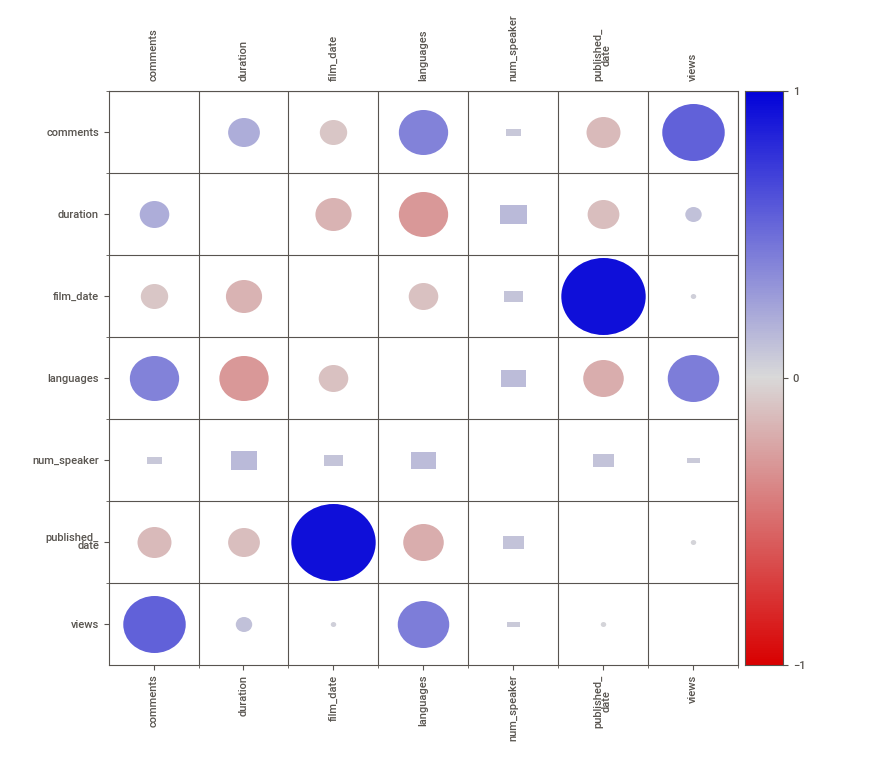
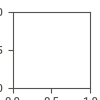

In [10]:
#EDA using Autoviz
sweet_report = sv.analyze(df)

#Saving results to HTML file
sweet_report.show_html('sweet_report.html')

#Displaying HTML EDA file
import IPython
IPython.display.HTML('sweet_report.html')

## Text Processing 

In [11]:
# Cleaning Text
def clean_text(text):
    # Removing Unnecessary Text
    text = str(text)
    text = re.sub(r'\([^)]*\)', ' ', text) # removing audience actions**
    text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', ' ', text) # url-less links
    text = re.sub(r'^https?:\/\/.*[\r\n]*', ' ', text, flags=re.MULTILINE) # links/urls 
    text = re.sub(r'#\S+', '', text)    # hastags  
    text = re.sub(r'[^\w\s]','', text)  # punctuation
    text = re.sub('[0-9]+', '', text)  # times
    text = re.sub('\s{2,}', ' ', text)  # over use of spaces
    text = text.lower()

    return text

In [12]:
# Applying Text Cleaning
df.transcript = df.transcript.apply(clean_text)

In [13]:
# Removing built-in stopwords
extras = []
stop_words = set(stopwords.words('english'))
stop_words.update(extras)

df['transcript'] = df.transcript.apply(lambda x: " ".join(term for term in x.split() if term not in stop_words))

In [14]:
# SnowballStemmer
def stem(text):
  stemmer = SnowballStemmer('english')
  return ''.join([stemmer.stem(word) for word in text])

# Lemmatizing
def lem(text):
  lemmatizer = WordNetLemmatizer()
  return ''.join([lemmatizer.lemmatize(word) for word in text])

In [15]:
df['transcript_lem'] = df.transcript.apply(lem)

# Content-Based Recommendation System

## TF-IDF Recommender

In [16]:
tfidf = TfidfVectorizer(stop_words=stop_words)
matrix = tfidf.fit_transform(df.transcript_lem)
matrix.shape

(2467, 97256)

In [20]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(matrix)

In [21]:
from item_recommender import ItemRecommender
tfidf_recommender = ItemRecommender()
tfidf_recommender.fit(matrix, titles=df.name)

In [22]:
print(tfidf_recommender.get_recommendations('Simon Sinek: How great leaders inspire action', n=10))

['Seth Godin: How to get your ideas to spread'
 'Scott Dinsmore: How to find work you love'
 'Tony Robbins: Why we do what we do'
 'Ricardo Semler: How to run a company with (almost) no rules'
 'Jeff Hawkins: How brain science will change computing'
 'Dan Gilbert: Why we make bad decisions'
 'Michael Norton: How to buy happiness'
 'Yuval Noah Harari: Nationalism vs. globalism: the new political divide'
 'Jessica Jackley: Poverty, money -- and love'
 'Seth Godin: The tribes we lead']


## LDA Recommender

In [23]:
n_com = 10
lda = LatentDirichletAllocation(n_com)
top_val = lda.fit_transform(matrix)

In [24]:
lda.components_.shape

(10, 97256)

In [25]:
lda_recommender = ItemRecommender()
lda_recommender.fit(top_val, titles=df.name)

In [26]:
print(lda_recommender.get_recommendations('Simon Sinek: How great leaders inspire action', n=10))

['John Maeda: How art, technology and design inform creative leaders'
 'Sylvia Earle: My wish: Protect our oceans'
 "Kandice Sumner: How America's public schools keep kids in poverty"
 'David Deutsch: Chemical scum that dream of distant quasars'
 "Colin Camerer: When you're making a deal, what's going on in your brain?"
 'Mona Chalabi: 3 ways to spot a bad statistic'
 'Marvin Minsky: Health and the human mind' 'Alain de Botton: Atheism 2.0'
 'Hans Rosling: New insights on poverty'
 'Andrew Mwenda: Aid for Africa? No thanks.']
